# Class 11 - Artificial Neural Networks

An *artificial neural network* (ANN) is a model of computation inspired by the structure of neural networks in the brain. It can be described as a directed graph whose nodes correspond to neurons and edges correspond to links between them, where each neuron receives as input a weighted sum of the outputs of the neurons connected to its incoming edges, and has an activation according to this input.

We will focus on *feedforward* neural networks in which the underlying graph does not contain cycles. Given a directed acyclic graph $G=(V, E)$, we have a weight function over the edges $ w : E \to \mathbb{R}$, biases $b:V \to \mathbb{R}$ for an activation threshold for neurons, and each neuron is modeled as a scalar function $\sigma : \mathbb{R} \to \mathbb{R}$, called the *activation function* of the neuron.

In order to learn non-linear function approximators for classification and regression, non-linear activation functions are used. The widely used non-linear activation functions are:
1. the logistic function $$\sigma(a)=\frac{1}{1+\exp(-a)},$$
2. the hyperbolic tangent function $$ \tanh(a)=\frac{e^a - e^{-a}}{e^a + e^{-a}},$$
3. the rectified linear unit (relu) function $$ \text{relu}(a)=\max \{0,a\}.$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

line = np.linspace(-3, 3, 100)
plt.plot(line, np.tanh(line), label="tanh")
plt.plot(line, np.maximum(line, 0), label="relu")
plt.legend(loc="best")
plt.show()

We will use the logistic function as the activation in each neuron, and we will also need its derivative later on.

In [ ]:
#Logistic function and its derivative 
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z)) 

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z)) 

line = np.linspace(-5, 5, 100)
plt.plot(line, sigmoid(line), label="sigmoid")
plt.plot(line, sigmoid_prime(line), label="sigmoid_prime")
plt.legend(loc="best")
plt.show()

## Multi-layer perceptron (MLP)

### Network architecture

We will assume that the network is organized in *layers* so that the set of nodes is a union of nonempty disjoint subsets $  V = \sqcup_{t=1}^{T} V_t$ such that every edge in $E$ connects some node in $V_{t}$ to some node in $V_{t+1}$ for some $t \in [T]-1$. Multi-layer perceptrons are *fully connected*, that is, all outputs of one layer are connected to each input of the next layer.

The bottom layer $V_1$ is called the *input layer*. It contains $d$ neurons, where $d$ is the dimension of the input space.
Layers $V_2,\dots,V_{T-1}$ are calles the *hidden layers*. The top layer $V_T$ is called the *output layer*. 

$T$ is called the *depth* of the network, the *size* of the network is $|V|$, and the *width* of the network is $\max_t |V_t|$.

Here is an example of a feedforward neural network of depth 3, size 9, and width 4.

We will focus on binary classification where the output layer will consist of a single neuron, though neural networks can also be used for multi-class classification and regression.

If we choose an *architecture* for the network by fixing the graph $(V,E)$ and the activation function $\sigma$, we can define a hypothesis class of neural network predictors

$$\mathcal{H}_{V,E,\sigma}=\{ h_{w,b}:\mathbb{R}^{d} \to \mathbb{R} \ | \ w : E \to \mathbb{R}, \ b : V \to \mathbb{R}\}$$ 

so that the parameters specifying a hypothesis are the weights and the biases.

Advantages of MLP:

- Capability to learn non-linear models.
- Capability to learn models online, that is, processing each observation one at a time (by using SGD).

Disadvantages of MLP:

- MLP with hidden layers have a non-convex loss function where there exists more than one local minimum.
- MLP requires tuning a number of hyperparameters such as the number of hidden neurons, layers, and iterations.
- MLP is sensitive to feature scaling. It is best to standardize all inputs beforehand.

###  Feedforward

We first need to understand how our function $h_{w,b}$ acts on a given input $x = \begin{bmatrix}x^{(1)} \\ \vdots \\x^{(d)}\end{bmatrix}$. This is done in a layer-by-layer forward manner.

The input layer has $d$ neurons and we set the output of the $i$th neuron to be the component $x^{(i)}$ of $x$.

Let us denote by $w_{jk}^{t}$ the weight from the $k$th neuron in layer $t-1$ to the $j$th neuron in layer $t$, and by $b_{j}^{t}$ the bias of the $j$th neuron in layer $t$.

With these notations, the *weighted input* $z_{j}^{t}$ to the $j$th neuron in layer $t$ is

$$z_{j}^{t} = \sum_{k=1}^{|V_{t-1}|} w_{jk}^{t} a_{k}^{t-1} + b_{j}^{t},$$

and the output (*activation*) $a_{j}^{t}$ of the $j$th neuron in layer $t$ is given by 

$$a_{j}^{t}  = \sigma(z_{j}^{t}) = \sigma \left(\sum_{k=1}^{|V_{t-1}|} w_{jk}^{t} a_{k}^{t-1} + b_{j}^{t} \right).$$
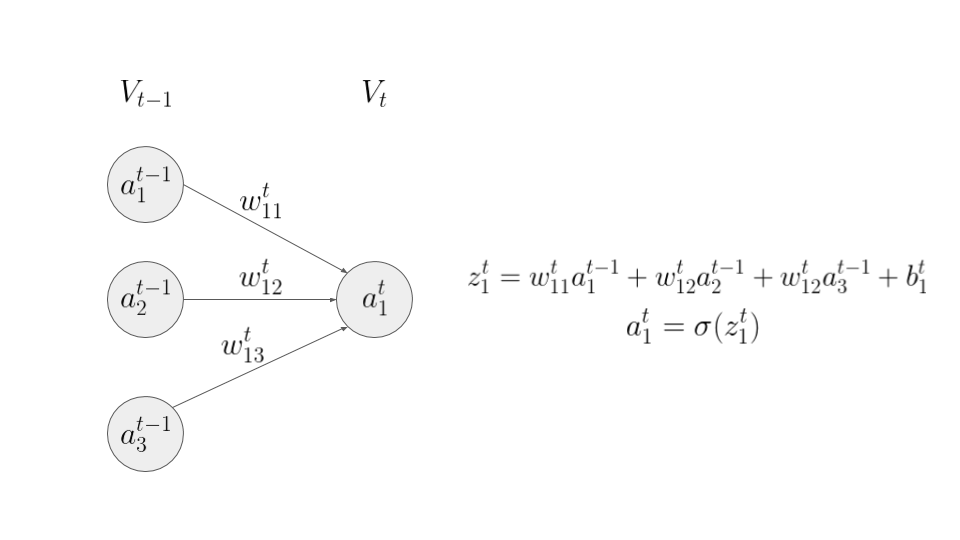
Rewriting the expressions in matrix form, for each layer $t$ we have a *weight matrix* $w^{t} = [w_{jk}^{t}]$, a *bias vector* $b^{t} = [b_{j}^{t}]$, a weighted input vector $z^{t} = [z_{j}^{t}]$ and an activation vector $a^{t} = [a_{j}^{t}]$, so that

$$ a^{t} = \sigma(z^{t}) = \sigma (w^{t} a^{t-1} + b^{t}),$$

where the activation function $\sigma$ is applied to each component of the given vector.

In [ ]:
def feedforward(a, weights, biases): ##input a is a column vector.
        #Returns the output of the network for the input x.
        for b, w in zip(biases, weights):
            a = sigmoid(w.dot(a)+b)
        return a

def feedforward_all(x, weights, biases): ## Applies the feedforward to several samples.
    n,d=x.shape
    output=np.zeros(n)
    for i in range(n):
        a = x[i,:].reshape(-1,1)
        output[i]=feedforward(a, weights, biases)
    return output

### Loss minimization

The problem of finding a hypothesis in $\mathcal{H}_{V,E,\sigma}$ with a low risk amounts to the problem of tuning the weights over the edges. Taking the squared loss, we may consider the regularized risk minimization

$$argmin_{w,b}  \left(\frac{\lambda}{2} \| w \|^2 + \frac{1}{n} \sum_{i=1}^{n} \frac{1}{2} \| y_i - h_{w,b}(x_i)\|^2\right).$$

Regularization can be used to prevent overfitting, especially when there is a high number of neurons in hidden layers. Note that we do not include the biases in the regularization term.

In [ ]:
def reg_risk(y_pred, y, l, weights, biases):
       
    reg_term = 0.5 * l * sum(np.linalg.norm(w)**2 for w in weights)
   
    squared_error_term = np.linalg.norm(y_pred - y)**2 / (2 * len(y))
        
    return reg_term + squared_error_term

One can also consider the log-loss function (also referred to as cross-entropy) for classification problems, which may lead to improvements on the algorithm.

For this optimization problem, we will use the stochastic gradient descent (SGD) algorithm to heuristically search for good weights and biases.

### Initialization

To start training our algorithm we need to choose initial values for the weights and biases.

An initialization for the weights and the biases with all being equal to zero will lead all hidden neurons to have the same weights. Starting instead with large weights often leads to poor solutions. So, we will initialize the weights and biases close to zero by using a Gaussian distribution with mean 0 and variance 1. 

Note that in our code we will specify the number of layers and the number of neurons in each layer simply by using a list. We also specify the weights and biases as lists of arrays to distinguish weight matrices and bias vectors in each layer. We do not set biases for the input layer.

In [ ]:
#Number of neurons in each layer given as a list. 
layer_config = [2, 4, 3, 1] ## As an example.

## Random initialization of weights and biases.
biases = [np.random.randn(t,1) for t in layer_config[1:]]
weights = [np.random.randn(k,j) for j,k in zip(layer_config[:-1], layer_config[1:])]
            ## order reversed for weight matrices with correct size.
print(weights)
print(biases)

### Stochastic gradient descent

For applying the SGD algorithm to neural networks, we may need certain modifications:

- Since the loss function is non-convex and possessing many local minima, the solution we aim to obtain is dependent on the choice of starting values. We may therefore need to repeat the minimization procedure several times with new random initializations so that one will lead to a good local minimum. 
- Unlike a fixed learning rate as we considered in convex problems, due to the nonconvexity of the loss we may need to utilize an *adaptive learning rate* with variable step sizes $\eta_i$. It is tuned in practice by a trial and error manner. Other techniques like mini-batch SGD can also be applied. Our attempt will be with fixed learning rate $\eta$.

$\quad \quad \quad$ **SGD for MLP**:

**Input**: Training dataset $(x_1, y_1), \ldots, (x_n, y_n)$, learning rate $\eta$, regularization parameter $\lambda >0$, number of iterations $\tau$.

**Initialize**: Choose the initial weights $w^{(1)}$ and the biases $b^{(1)}$ at random (from a distribution such that the values are close enough to $0$).

**for** $i = 1, 2, 3, \ldots, \tau$:

$\quad$ Choose $j$ uniformly at random from $\{1, 2, \ldots, n\}$.

$\quad$ Calculate the gradients $\nabla_{w^{(i)}}, \nabla_{b^{(i)}} = \text{backpropagation}(x_j, y_j, w^{(i)}, b^{(i)})$.

$\quad$ Update \begin{align} w^{(i+1)} &= w^{(i)} - \eta (\nabla_{w^{(i)}} + \lambda w^{(i)}), \\ b^{(i+1)} &= b^{(i)} - \eta \nabla_{b^{(i)}}. \end{align}

**return**: $\bar{w}, \bar{b}$ are the best performing $w^{(i)}, b^{(i)}$.

In [ ]:
def neural_network_train(x, y, layer_config, l=0.1, eta=0.001, max_iter=10**3, verbose=True, seed=None):
    np.random.seed(seed)
    n,d = x.shape
    
    ##Random initialization
    weights = [np.random.randn(k,j) for j,k in zip(layer_config[:-1], layer_config[1:])]
    biases = [np.random.randn(t,1) for t in layer_config[1:]]
    #biases = [np.zeros((t,1)) for t in layer_config[1:]]
    
    a = feedforward_all(x, weights, biases)
    risk_new = reg_risk(a, y, l, weights, biases)
    
    best_weights = weights
    best_biases = biases
    best_risk = np.Inf
      
    for i in range(1, max_iter+1):
        random_index = np.random.randint(0, n)     
        a = x[random_index,:].reshape(-1,1)
        nabla_w, nabla_b = backprop(a, y[random_index], layer_config, weights, biases)
        weights = [w -   eta * (l * w + nw) for w, nw in zip(weights, nabla_w)] ##(eta / (10**(-7) + np.linalg.norm(l * w + nw)))
        biases = [b -  eta * nb for b, nb in zip(biases, nabla_b)] ## (eta / (10**(-7) + np.linalg.norm(nb)))
        
        y_pred = feedforward_all(x, weights, biases)
        risk_new = reg_risk(y_pred, y, l, weights, biases)
        if risk_new < best_risk:
            best_weights = weights
            best_biases = biases
            best_risk = risk_new
            
        if verbose == True:    
            print('iter =', i,':', risk_new)
                   
    return best_weights, best_biases

### Backpropagation

In order to apply the SGD algorithm above, we need to be able to compute the gradient of the loss function in an efficient way. Due to the compositional form of the hypotheses, the gradient can be derived using the chain rule for differentiation. This can be computed by a forward and backward sweep over the network, called *backpropagation*.

For a single training example $(x,y)$, let us consider the loss

$$l(y, h_{w,b}(x))= \frac{1}{2} \| y - a^T(x)\|^2. $$

To compute the partial derivatives $\displaystyle \frac{\partial l}{\partial w_{jk}^{t}}$ and $\displaystyle \frac{\partial l}{\partial b_{j}^{t}}$, we define the error in the $j$th neuron in layer $t$ by $\displaystyle \delta_{j}^{t} = \displaystyle \frac{\partial l}{\partial z_{j}^{t}}$, and let $\delta^{t}$ denote the vector of errors associated with layer $t$.

We start with the output layer $T$, where we have $$ \delta_{j}^{T} = \frac{\partial l}{\partial a_{j}^{t}} \sigma'(z_{j}^{T}).$$ 

In matrix form, using the notation $u \odot v$ for the elementwise product of the two vectors, we get 

$$\delta^{T} = (a^{T}-y) \odot \sigma'(z^{T}).$$

Then the error $\delta^{t}$ in terms of the error $\delta^{t+1}$ in the next layer is given by 

$$\delta^{t} = (w^{t+1})^{\top} \delta^{t+1} \odot \sigma'(z^{t}),$$ 

where $(w^{t+1})^{\top}$ is the transpose of the weight matrix for the layer $t+1$.

In this way, we can compute the error $\delta^{t}$ for any layer in the network by starting $\delta_{j}^{T}$ and going backwards through layers. 

Then, we can compute the partial derivatives by the formulas

$$ \frac{\partial l}{\partial b_{j}^{t}} = \delta_{j}^{t} \quad \text{and} \quad \frac{\partial l}{\partial w_{jk}^{t}} = a_{k}^{t-1} \delta_{j}^{t}.$$

$\quad \quad \quad$ **Backpropagation**:

**Input**: Training sample $(x,y)$, network $(V,E)$ with layers $t=1,\dots,T$, weights $w_{jk}^{t}$ and biases $b_{j}^{t}$. 

**Feedforward**: 

$\quad$ Set $a^{0}=x$.

$\quad$ **for** $t=2,3,\dots,T$: 

$\quad$ $\quad$ Compute $z^{t} = w^{t}a^{t-1} + b^{t}$ and $a^{t} = \sigma(z^{t})$.

**Backpropagate the error**: 

$\quad$ Compute $\delta^{T} = (a^{T}-y) \odot \sigma'(z^{T})$.

$\quad$ **for** $t=T-1,T-2,\dots, 2$:

$\quad$ $\quad$ Compute $\delta^{t} = (w^{t+1})^{\top} \delta^{t+1} \odot \sigma'(z^{t})$.

**return**: $\displaystyle \frac{\partial l}{\partial b_{j}^{t}} = \delta_{j}^{t}$ and $\displaystyle \frac{\partial l}{\partial w_{jk}^{t}} = a_{k}^{t-1} \delta_{j}^{t}$.

In [ ]:
def backprop(x, y, layer_config, weights, biases):
    
    num_layer = len(layer_config)
    
    def delta(z, a, y):
        return (a-y) * sigmoid_prime(z)
    
    nabla_w = [np.zeros(w.shape) for w in weights] 
    nabla_b = [np.zeros(b.shape) for b in biases]
       
        
    ## feedforward with each weighted input and activation stored.
    activation = x
    activations = [x] ## list to store all activation vectors layer by layer.
    zs = [] ## list to store all weighted input vectors layer by layer.
    for w, b in zip(weights, biases):
        z = w.dot(activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    
    ## backpropagate the errors.
    delta = delta(zs[-1], activations[-1], y)
    nabla_b[-1] = delta
    nabla_w[-1] = delta.dot(np.transpose(activations[-2]))
    
    for t in range(2, num_layer):
        z=zs[-t]
        sp = sigmoid_prime(z)
        delta = np.transpose(weights[-t+1]).dot(delta) * sp
        nabla_b[-t] = delta
        nabla_w[-t] = delta.dot(np.transpose(activations[-t-1]))
    
    return nabla_w, nabla_b

Let us apply our algorithm to a toy example.

In [ ]:
from sklearn import datasets
x, y = datasets.make_moons(n_samples=300, shuffle=True, noise=0.2, random_state=5)

def shuffle(x, y):
    y = y.reshape(-1,1)
    z = np.hstack((x, y))
    np.random.shuffle(z)
    x_new, y_new = np.hsplit(z, [x.shape[1]])
    return x_new, y_new.reshape(-1)

def splitting(x, y, test_size=0.2):
    n = x.shape[0]
    train_size = int(n * (1 - test_size))
    return x[:train_size, ], x[train_size:, ], y[:train_size, ], y[train_size:, ]

x, y = shuffle(x, y)
x_train, x_test, y_train, y_test = splitting(x, y)

x_mean = np.mean(x_train, axis=0)
x_std = np.std(x_train, axis=0)
x_train = (x_train - x_mean) / x_std

plt.scatter(x_train[:,0], x_train[:,1], c=y_train)
plt.show()

Since the $x$ values are two dimensional, we have two neurons in the input layer, and a single neuron for binary classification in the output layer. Let us take a single hidden layer with 16 neurons.

In [ ]:
layer_config=[2, 16, 1] 
weights, biases = neural_network_train(x_train, y_train, layer_config, l=0, eta=1, max_iter=5000, verbose=True)

print(weights, biases)

For binary classification, the output layer has a single neuron which outputs values between zero and one after applying the logistic activation function. We can then assign samples of outputs greater than or equal to 0.5 to one class, and otherwise to the other class.

In [ ]:
def neural_network_predict(x, weights, biases):
    predictions = feedforward_all(x, weights, biases)
    
    for i in range(len(predictions)):
        if predictions[i] >= 0.5:
            predictions[i] = 1
        else:
            predictions[i] = 0
            
    return predictions

def zero_one_loss(y_pred, y_true):
    n = len(y_true)
    return (1/n) * np.sum(y_true != y_pred)

print('train 0-1 loss :', zero_one_loss(neural_network_predict(x_train, weights, biases),y_train))
print('test 0-1 loss :', zero_one_loss(neural_network_predict((x_test - x_mean) / x_std, weights, biases),y_test))
## Predictions and true outputs side by side.
#print(np.transpose(np.vstack((neural_network_predict((x_test - x_mean) / x_std, weights, biases),y_test))))

Let us also plot a decision boundary to get an understanding of how our algorithm makes predictions.

In [ ]:
# Draws the decision boundary for a classifier with two features
def decision_boundary(plt, x1_range, x2_range):
    # Create grid
    xx1, xx2 = np.meshgrid(np.arange(x1_range[0], x1_range[1], 0.1),
                     np.arange(x2_range[0], x2_range[1], 0.1))
    
    # Predict on all values
    y = neural_network_predict(np.c_[xx1.reshape(-1), xx2.reshape(-1)], weights, biases)
    #y = clf.predict(np.c_[xx1.reshape(-1), xx2.reshape(-1)])
    y = y.reshape(xx1.shape)
    
    # Plot contour
    plt.contourf(xx1, xx2, y, alpha=0.4)

# Plot both training and testing
f, subplt = plt.subplots(1, 2, figsize=(12, 5))
x1_range = [x_train[:, 0].min() - 1/2, x_train[:, 0].max() + 1/2]
x2_range = [x_train[:, 1].min() - 1/2, x_train[:, 1].max() + 1/2]

subplt[0].set_title("training set")
decision_boundary(subplt[0], x1_range, x2_range)
subplt[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolor='k')

subplt[1].set_title("test set")
decision_boundary(subplt[1], x1_range, x2_range)
subplt[1].scatter(((x_test - x_mean)/x_std)[:, 0], ((x_test - x_mean)/x_std)[:, 1], c=y_test, edgecolor='k')


plt.show()

### Architecture

To see how different numbers of layers and neurons effect the algorithm, let us look at the example of two concentric circles.

In [ ]:
x_one, y_one = datasets.make_circles(n_samples=150, shuffle=True, noise=0.25, random_state=2, factor=0.1)
x_one = x_one + 2
x_two, y_two = datasets.make_circles(n_samples=150, shuffle=True, noise=0.25, random_state=5, factor=0.1)

x = np.vstack((x_one, x_two))
y = np.hstack((y_one, y_two))

plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

In [ ]:
x, y = shuffle(x, y)
x_train, x_test, y_train, y_test = splitting(x, y)

x_mean = np.mean(x_train, axis=0)
x_std = np.std(x_train, axis=0)
x_train = (x_train - x_mean) / x_std

Assigning different number of layers and neurons and plotting the related decision boundaries, we may see the different ways the algorithm makes predictions.

In [ ]:
#architectures = [[2,7,1], [2,16,1], [2,16,1,1], [2,8,8,1]]
architectures = [[2,1], [2,4,1], [2,16,1],  [2, 16, 32, 1]]

for layer_config in architectures:
    weights, biases = neural_network_train(x_train, y_train, layer_config, l=0, eta=1, max_iter=5000, verbose=False)
    
    print('layer_config :', layer_config)
    print('train 0-1 loss :', zero_one_loss(neural_network_predict(x_train, weights, biases),y_train))
    print('test 0-1 loss :', zero_one_loss(neural_network_predict((x_test - x_mean) / x_std, weights, biases),y_test))
    
    # Plot both training and testing
    f, subplt = plt.subplots(1, 2, figsize=(12, 5))
    x1_range = [x_train[:, 0].min() - 1/2, x_train[:, 0].max() + 1/2]
    x2_range = [x_train[:, 1].min() - 1/2, x_train[:, 1].max() + 1/2]

    subplt[0].set_title("training set")
    decision_boundary(subplt[0], x1_range, x2_range)
    subplt[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolor='k')

    subplt[1].set_title("test set")
    decision_boundary(subplt[1], x1_range, x2_range)
    subplt[1].scatter(((x_test - x_mean)/x_std)[:, 0], ((x_test - x_mean)/x_std)[:, 1], c=y_test, edgecolor='k')

    plt.show()

### Learning rate

To illustrate the sensitivity of risk to the learning rate and the importance of choosing the learning rate carefully, let us plot how risk changes with initial iterations for different values of $\eta$.

In [ ]:
## Learning rate coefficients in log-scale.
log_coef=np.linspace(-3, 2, 6)
eta_list=10**log_coef

## Function for storing the risk during the training.
def neural_network_risk_change(x, y, layer_config, l=0.1, eta=0.001, max_iter=10**3, seed=None):
    np.random.seed(seed) # fix seed to get same initialization for each output
    
    n,d = x.shape

    weights = [np.random.randn(k,j) for j,k in zip(layer_config[:-1], layer_config[1:])]
    biases = [np.random.randn(t,1) for t in layer_config[1:]]
    
    risk_old = 0.
    a = feedforward_all(x, weights, biases)
    risk_new = reg_risk(a, y, l, weights, biases)
    
    losses=[]
    risk = 1000 
    for i in range(1, max_iter+1):
        random_index = np.random.randint(0, n)     
        a = x[random_index,:].reshape(-1,1)
        nabla_w, nabla_b = backprop(a, y[random_index], layer_config, weights, biases)
        weights = [w -  eta * (l * w + nw) for w, nw in zip(weights, nabla_w)] 
        biases = [b - eta * nb for b, nb in zip(biases, nabla_b)] 
        
        y_pred = feedforward_all(x, weights, biases)
        risk_new, risk_old = reg_risk(y_pred, y, l, weights, biases), risk_new
        
        if risk_new < risk:
            risk=risk_new
        
        losses.append(risk)

    return losses

## Plot the loss vs. iterations for different learning rates.
for etat in eta_list:
    losses=neural_network_risk_change(x_train, y_train, [2,16,1], l=0, eta=etat, max_iter=1000, seed=36)
    print('eta = ', etat)                   
    plt.plot(losses)
    plt.show()

In [ ]:
log_coef=np.linspace(-3, 2, 6)
eta_list=10**log_coef


for etat in eta_list:
    errors_reg_risk=[]
    errors_zero_one=[]
    for iteration in range(1,1000,25): ## Up to 100 iterations.
        weights, biases = neural_network_train(x_train, y_train, [2,16,1], l=0, eta=etat, max_iter=iteration, verbose=False, seed=36)
        errors_reg_risk.append(reg_risk(feedforward_all(x_train, weights, biases), y_train, 0, weights, biases))
        errors_zero_one.append(zero_one_loss(neural_network_predict(x_train, weights, biases), y_train))
    print('eta = ', etat)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    ax[0].set_title("0-1 loss")
    ax[0].plot(errors_zero_one)
    ax[1].set_title("quadratic loss")
    ax[1].plot(errors_reg_risk)
    plt.tight_layout()
    plt.show()

Note that the learning rate could be very difficult to set in general because if we set it too small, then the parameter update will be very slow and it will take very long time to achieve an acceptable loss. If we set it too large, then the parameters will move all over the function and may never achieve acceptable loss at all. The learning rate could also be too small in some dimension and could be too large in another dimension.

### Scikit-learn

The multi-layer perceptron classifier in scikit-learn can be implemented similar to our implementation as follows. The model optimizes the log-loss function instead of the squared loss. It also allows different activation functions and different solvers, some equipped with adaptive learning rates. For more information, see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier).

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(16,), activation='logistic', solver='sgd', alpha=0, batch_size=1, learning_rate='constant', learning_rate_init=1, max_iter=200, momentum = 0)
clf.fit(x_train,y_train)
print('Mean accuracy train:',clf.score(x_train,y_train))
print('Mean accuracy test:',clf.score((x_test - x_mean)/x_std,y_test))
#print(np.transpose(np.vstack((clf.predict((x_test - x_mean) / x_std), y_test))))

## Practice yourself!

1. Implement the MLP algorithm using the log-loss $$l(y, y') =   - \left[ y \log\left( y' \right) + (1 - y) \log\left( 1 - y'\right) \right].$$

2. Update the MLP algorithm above for multi-class classification. How would you make predictions using the multioutput from the output layer? Try to use the *softmax* function 
$$\text{softmax} (z)_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}, \quad i=1,\dots,K, \quad z=(z_1,\dots,z_k) \in \mathbb{R}^k.$$

3. Implement your algorithm from Exercise 2 to the [iris dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html) from scikit-learn.

3. Use crossvalidation to tune the regularization hyperparameter $\lambda$ for a hidden layer with 100 neurons. What is the effect of changing $\lambda$?  

4. Derive the partial derivative formulas in the backpropagation algorithm.